# Build a Customer Support Router Agentic RAG System

In this project, we will leverage the power of AI Agents and RAG Systems to build an intelligent Router Agentic RAG System to handle customer support queries using a custom knowledgebase.

![](https://i.imgur.com/bLCdxCI.png)

### Intelligent Router Agentic RAG System

This project focuses on building an **Intelligent Router Agentic RAG System** that combines intelligent query analysis, sentiment detection, and dynamic routing with Retrieval-Augmented Generation (RAG) to handle diverse user inquiries efficiently. The workflow includes the following components:

1. **Query Categorization and Sentiment Analysis**:
   - The system uses **OpenAI GPT-4o** to analyze the user's query and determine:
     - **Query Category**: Identifies the type of problem, such as billing, technical issues, or general queries.
     - **User Sentiment**: Evaluates the user's sentiment (positive, neutral, or negative) to determine if escalation is needed.

2. **Intelligent Routing**:
   - Based on the **query_category** and **query_sentiment**, the system routes the query to the appropriate handling node:
     - **Escalate to Human**: If the sentiment is negative, the query is escalated to a human for resolution.
     - **Generate Billing Response**: Queries related to billing are routed to generate an appropriate response.
     - **Generate Technical Response**: Technical queries are routed for a specialized technical response.
     - **Generate General Response**: General queries are handled with context-aware responses.

3. **Knowledge Base Integration (RAG)**:
   - The system integrates with a **Knowledge Base (Vector Database)** to augment responses with relevant and accurate information.
   - Retrieval-Augmented Generation (RAG) ensures that responses are grounded in the latest and most reliable data.

4. **Escalation Mechanism**:
   - Negative sentiment triggers an **escalation to a human**, ensuring the user receives empathetic and personalized support for critical issues.


In [2]:
# !pip install langchain-chroma==0.2.0

## Load Company Knowledge Base

In [3]:
# or download manually from https://drive.google.com/file/d/1CWHutosAcJ6fiddQW5ogvg7NgLstZJ9j/view?usp=sharing and upload to colab or your notebook location
# !gdown 1CWHutosAcJ6fiddQW5ogvg7NgLstZJ9j

In [1]:
import json

with open("./docs/router_agent_documents.json", "r") as f:
    knowledge_base = json.load(f)

knowledge_base[:3]

[{'text': 'Question: How do I integrate your AI product with my existing CRM system? Answer: You can integrate our AI product with your CRM using our API. Refer to the API documentation available on our website for step-by-step guidance.',
  'metadata': {'category': 'technical'}},
 {'text': 'Question: What programming languages are supported by your SDK? Answer: Our SDK supports Python, Java, and JavaScript. Additional language support is planned for future updates.',
  'metadata': {'category': 'technical'}},
 {'text': 'Question: Can your AI models run on-premise? Answer: Yes, our AI models can be deployed on-premise. We provide deployment guides for various environments.',
  'metadata': {'category': 'technical'}}]

In [20]:
knowledge_base[-3:]

[{'text': 'Question: How do I escalate an unresolved issue? Answer: You can escalate unresolved issues by emailing our escalation team at escalations@example.com.',
  'metadata': {'category': 'general'}},
 {'text': 'Question: Do you have a reseller program? Answer: Yes, we have a reseller program. Please contact our sales team for details.',
  'metadata': {'category': 'general'}},
 {'text': 'Question: What is your policy for handling damaged hardware deliveries? Answer: If you receive damaged hardware, please report it within 48 hours to our support team. We will arrange for a replacement.',
  'metadata': {'category': 'general'}}]

In [21]:
from langchain_core.documents import Document  # New import
from tqdm import tqdm

processed_docs = []

for doc in tqdm(knowledge_base):
    metadata = doc['metadata']
    data = doc['text']
    processed_docs.append(Document(page_content=data,
                                   metadata=metadata))

processed_docs[:3]

100%|██████████| 30/30 [00:00<00:00, 120410.64it/s]


[Document(metadata={'category': 'technical'}, page_content='Question: How do I integrate your AI product with my existing CRM system? Answer: You can integrate our AI product with your CRM using our API. Refer to the API documentation available on our website for step-by-step guidance.'),
 Document(metadata={'category': 'technical'}, page_content='Question: What programming languages are supported by your SDK? Answer: Our SDK supports Python, Java, and JavaScript. Additional language support is planned for future updates.'),
 Document(metadata={'category': 'technical'}, page_content='Question: Can your AI models run on-premise? Answer: Yes, our AI models can be deployed on-premise. We provide deployment guides for various environments.')]

In [49]:
# ============================================================================
# SETUP: Import LLM Helper Functions
# ============================================================================
# We use helper functions to create LLM instances with proper configuration
# These functions handle API key loading and model configuration

import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath("../.."))

# Import our LLM factory functions
# - get_groq_llm(): Creates a Groq-hosted LLM (fast inference)
# - get_openai_llm(): Creates an OpenAI GPT model
from helpers.utils import get_groq_llm, get_openai_llm,get_databricks_llm

print("LLM helpers imported successfully!")

# ============================================================================
# CREATE THE LLM AND CHATBOT GRAPH
# ============================================================================

# -----------------------------------------------------------------------------
# Step 1: Initialize the LLM
# We use Groq for fast inference, but you can swap to OpenAI
# -----------------------------------------------------------------------------
llm = get_databricks_llm("databricks-claude-sonnet-4")  # Fast, open-source models hosted by Groq
# Alternative: llm = get_openai_llm()  # OpenAI's GPT models

if hasattr(llm, 'model_name'):
    print(f"LLM initialized: {llm.model_name}")
elif hasattr(llm, 'model'):
    print(f"LLM initialized: {llm.model} (Databricks)")
else:
    print("LLM initialized: Groq LLM")

LLM helpers imported successfully!
LLM initialized: databricks-claude-sonnet-4 (Databricks)


## Create Vector Database

In [50]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [51]:
from langchain_chroma import Chroma

kbase_db = Chroma.from_documents(documents=processed_docs,
                                  collection_name='knowledge_base',
                                  embedding=openai_embed_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./knowledge_base")

In [52]:
kbase_search = kbase_db.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs={"k": 3, "score_threshold": 0.2})

In [53]:
query = 'what is your refund policy?'
metadata_filter = {'category' : 'general'}
# Update retriever search_kwargs dynamically
kbase_search.search_kwargs["filter"] = metadata_filter
kbase_search.invoke(query)

[Document(id='e1b03877-f678-4132-a2ca-2083a65a3c70', metadata={'category': 'general'}, page_content='Question: What is your refund policy? Answer: We offer a 30-day money-back guarantee for all our products. Please contact support to initiate a refund.'),
 Document(id='07ab1972-ca4a-493d-a6cc-9033934fb505', metadata={'category': 'general'}, page_content='Question: What is your refund policy? Answer: We offer a 30-day money-back guarantee for all our products. Please contact support to initiate a refund.'),
 Document(id='c04b477d-e42f-4612-88df-b4fd4b5023b2', metadata={'category': 'general'}, page_content='Question: What is your refund policy? Answer: We offer a 30-day money-back guarantee for all our products. Please contact support to initiate a refund.')]

In [54]:
query = 'what is your refund policy'
metadata_filter = {'category' : 'General'}
# Update retriever search_kwargs dynamically
kbase_search.search_kwargs["filter"] = metadata_filter
kbase_search.invoke(query)

No relevant docs were retrieved using the relevance score threshold 0.2


[]

In [55]:
query = 'what is your refund policy'
metadata_filter = {'category' : 'technical'}
# Update retriever search_kwargs dynamically
kbase_search.search_kwargs["filter"] = metadata_filter
kbase_search.invoke(query)

No relevant docs were retrieved using the relevance score threshold 0.2


[]

## Define the Customer Inquiry State

We create a `CustomerSupportState` typed dictionary to keep track of each interaction:
- **customer_query**: The text of the customer's question
- **query_category**: Technical, Billing, or General (used for routing)
- **query_sentiment**: Positive, Neutral, or Negative (used for routing)
- **final_response**: The system's response to the customer

In [56]:
from typing import TypedDict, Literal
from pydantic import BaseModel

class CustomerSupportState(TypedDict):
    customer_query: str
    query_category: str
    query_sentiment: str
    final_response: str

class QueryCategory(BaseModel):
    categorized_topic: Literal['Technical', 'Billing', 'General']

class QuerySentiment(BaseModel):
    sentiment: Literal['Positive', 'Neutral', 'Negative']

## Create Node Functions

Each function below represents a stage in processing a customer inquiry:

1. **categorize_inquiry**: Classifies the query into Technical, Billing, or General.
2. **analyze_inquiry_sentiment**: Determines if the sentiment is Positive, Neutral, or Negative.
3. **generate_technical_response**: Produces a response for technical issues.
4. **generate_billing_response**: Produces a response for billing questions.
5. **generate_general_response**: Produces a response for general queries.
6. **escalate_to_human_agent**: Escalates the query to a human if sentiment is negative.
7. **determine_route**: Routes the inquiry to the appropriate response node based on category and sentiment.

In [57]:
def categorize_inquiry(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Classify the customer query into Technical, Billing, or General.
    """

    query = support_state["customer_query"]
    ROUTE_CATEGORY_PROMPT = """Act as a customer support agent trying to best categorize the customer query.
                               You are an agent for an AI products and hardware company.

                               Please read the customer query below and
                               determine the best category from the following list:

                               'Technical', 'Billing', or 'General'.

                               Remember:
                                - Technical queries will focus more on technical aspects like AI models, hardware, software related queries etc.
                                - General queries will focus more on general aspects like contacting support, finding things, policies etc.
                                - Billing queries will focus more on payment and purchase related aspects

                                Return just the category name (from one of the above)

                                Query:
                                {customer_query}
                            """
    prompt = ROUTE_CATEGORY_PROMPT.format(customer_query=query)
    route_category = llm.with_structured_output(QueryCategory).invoke(prompt)

    return {
        "query_category": route_category.categorized_topic
    }

In [58]:
categorize_inquiry({"customer_query": "Do you provide pretrained models?"})

{'query_category': 'Technical'}

In [59]:
categorize_inquiry({"customer_query": "what is your refund policy?"})

{'query_category': 'General'}

In [60]:
categorize_inquiry({"customer_query": "what payment methods are accepted?"})

{'query_category': 'Billing'}

In [61]:
def analyze_inquiry_sentiment(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Analyze the sentiment of the customer query as Positive, Neutral, or Negative.
    """

    query = support_state["customer_query"]
    SENTIMENT_CATEGORY_PROMPT = """Act as a customer support agent trying to best categorize the customer query's sentiment.
                                   You are an agent for an AI products and hardware company.

                                   Please read the customer query below,
                                   analyze its sentiment which should be one from the following list:

                                   'Positive', 'Neutral', or 'Negative'.

                                   Return just the sentiment (from one of the above)

                                   Query:
                                   {customer_query}
                                """
    prompt = SENTIMENT_CATEGORY_PROMPT.format(customer_query=query)
    sentiment_category = llm.with_structured_output(QuerySentiment).invoke(prompt)

    return {
        "query_sentiment": sentiment_category.sentiment
    }

In [62]:
analyze_inquiry_sentiment({"customer_query": "what is your refund policy?"})

{'query_sentiment': 'Neutral'}

In [63]:
analyze_inquiry_sentiment({"customer_query": "what is your refund policy? I am really fed up with this product and need to refund it"})

{'query_sentiment': 'Negative'}

In [64]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Dict

def generate_technical_response(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Provide a technical support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering

    categorized_topic = support_state["query_category"]
    query = support_state["customer_query"]

    # Use metadata filter for 'technical' queries
    if categorized_topic.lower() == "technical":
        metadata_filter = {"category": "technical"}
        kbase_search.search_kwargs["filter"] = metadata_filter

        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)

        # Combine retrieved information into the prompt
        prompt = ChatPromptTemplate.from_template(
            """
            Craft a clear and detailed technical support response for the following customer query.
            Use the provided knowledge base information to enrich your response.
            In case there is no knowledge base information or you do not know the answer just say:

            Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx

            Customer Query:
            {customer_query}

            Relevant Knowledge Base Information:
            {retrieved_content}
            """
        )

        # Generate the final response using the LLM
        chain = prompt | llm
        tech_reply = chain.invoke({
            "customer_query": query,
            "retrieved_content": retrieved_content
        }).content
    else:
        # For non-technical queries, provide a default response or a general handling
        tech_reply = "Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx"

    # Update and return the modified support state
    return {
        "final_response": tech_reply
    }


In [65]:
generate_technical_response({"customer_query": "what is your refund policy?", "query_category": "General"})

{'final_response': 'Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx'}

In [66]:
generate_technical_response({"customer_query": "do you support on-prem models?", "query_category": "Technical"})

{'final_response': "Thank you for your inquiry about on-premise model support.\n\n**Yes, we do support on-premise models.** Our AI models can be deployed directly in your own infrastructure environment, giving you full control over your data and deployment.\n\n**What we provide:**\n- Complete on-premise deployment capability for our AI models\n- Comprehensive deployment guides tailored for various environments\n- Support for different infrastructure configurations\n\n**Next Steps:**\nTo get started with on-premise deployment, I recommend:\n1. Reviewing our deployment documentation specific to your environment\n2. Assessing your infrastructure requirements\n3. Contacting our technical team for deployment planning assistance\n\nIf you need specific deployment guides for your particular environment or have additional questions about hardware requirements, security configurations, or implementation timelines, please let me know and I'll be happy to provide more detailed information.\n\nIs 

In [67]:
def generate_billing_response(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Provide a billing support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering
    categorized_topic = support_state["query_category"]
    query = support_state["customer_query"]

    # Use metadata filter for 'billing' queries
    if categorized_topic.lower() == "billing":
        metadata_filter = {"category": "billing"}
        kbase_search.search_kwargs["filter"] = metadata_filter

        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)

        # Combine retrieved information into the prompt
        prompt = ChatPromptTemplate.from_template(
            """
            Craft a clear and detailed billing support response for the following customer query.
            Use the provided knowledge base information to enrich your response.
            In case there is no knowledge base information or you do not know the answer just say:

            Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx

            Customer Query:
            {customer_query}

            Relevant Knowledge Base Information:
            {retrieved_content}
            """
        )

        # Generate the final response using the LLM
        chain = prompt | llm
        billing_reply = chain.invoke({
            "customer_query": query,
            "retrieved_content": retrieved_content
        }).content
    else:
        # For non-billing queries, provide a default response or a general handling
        billing_reply = "Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx"

    # Update and return the modified support state
    return {
        "final_response": billing_reply
    }

In [68]:
generate_billing_response({"customer_query": "what payment methods are supported?", "query_category": "Billing"})

{'final_response': "Thank you for your inquiry about our supported payment methods.\n\nWe accept the following payment options:\n\n**Credit Cards** - We accept major credit cards for convenient online payments\n\n**PayPal** - You can pay securely using your PayPal account\n\n**Wire Transfers** - Available specifically for corporate accounts\n\nThese payment methods are designed to provide you with flexible options whether you're an individual customer or representing a corporate account. Credit cards and PayPal offer quick and convenient payment processing, while wire transfers provide a reliable option for our business customers with corporate accounts.\n\nIf you have any questions about setting up payments with any of these methods or need assistance with processing a payment, please don't hesitate to reach out to us.\n\nIs there anything specific about these payment methods that you'd like me to clarify for you?"}

In [69]:
def generate_general_response(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Provide a general support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering
    categorized_topic = support_state["query_category"]
    query = support_state["customer_query"]

    # Use metadata filter for 'general' queries
    if categorized_topic.lower() == "general":
        metadata_filter = {"category": "general"}
        kbase_search.search_kwargs["filter"] = metadata_filter

        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)

        # Combine retrieved information into the prompt
        prompt = ChatPromptTemplate.from_template(
            """
            Craft a clear and detailed general support response for the following customer query.
            Use the provided knowledge base information to enrich your response.
            In case there is no knowledge base information or you do not know the answer just say:

            Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx

            Customer Query:
            {customer_query}

            Relevant Knowledge Base Information:
            {retrieved_content}
            """
        )

        # Generate the final response using the LLM
        chain = prompt | llm
        general_reply = chain.invoke({
            "customer_query": query,
            "retrieved_content": retrieved_content
        }).content
    else:
        # For non-general queries, provide a default response or a general handling
        general_reply = "Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx"

    # Update and return the modified support state
    return {
        "final_response": general_reply
    }


In [70]:
generate_general_response({"customer_query": "what is your refund policy?", "query_category": "General"})

{'final_response': "Thank you for your inquiry about our refund policy.\n\n**Our Refund Policy:**\n\nWe offer a **30-day money-back guarantee** for all our products. This means you have 30 days from your purchase date to request a full refund if you're not completely satisfied with your purchase.\n\n**How to Request a Refund:**\n\nTo initiate a refund, please contact our support team directly. Our team will guide you through the process and ensure your refund is processed promptly.\n\n**Next Steps:**\n\nIf you'd like to proceed with a refund or have any questions about the process, please don't hesitate to reach out to our support team. We're here to help make the refund process as smooth as possible for you.\n\nIs there anything else about our refund policy that you'd like me to clarify?"}

In [71]:
def escalate_to_human_agent(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Escalate the query to a human agent if sentiment is negative.
    """

    return {
        "final_response": "Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!"
    }

In [72]:
def determine_route(support_state: CustomerSupportState) -> str:
    """
    Route the inquiry based on sentiment and category.
    """
    if support_state["query_sentiment"] == "Negative":
        return "escalate_to_human_agent"
    elif support_state["query_category"] == "Technical":
        return "generate_technical_response"
    elif support_state["query_category"] == "Billing":
        return "generate_billing_response"
    else:
        return "generate_general_response"

## Build and Compile the Workflow

We construct a LangGraph workflow with the nodes defined above:
1. **categorize_inquiry** → **analyze_inquiry_sentiment** → **route** to the proper response node.
2. If negative, escalate to a human agent.
3. Otherwise, produce an appropriate response (technical, billing, or general).

In [73]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# Create the graph with our typed state
customer_support_graph = StateGraph(CustomerSupportState)

# Add nodes for each function
customer_support_graph.add_node("categorize_inquiry", categorize_inquiry)
customer_support_graph.add_node("analyze_inquiry_sentiment", analyze_inquiry_sentiment)
customer_support_graph.add_node("generate_technical_response", generate_technical_response)
customer_support_graph.add_node("generate_billing_response", generate_billing_response)
customer_support_graph.add_node("generate_general_response", generate_general_response)
customer_support_graph.add_node("escalate_to_human_agent", escalate_to_human_agent)

# Add edges to represent the processing flow
customer_support_graph.add_edge("categorize_inquiry", "analyze_inquiry_sentiment")
customer_support_graph.add_conditional_edges(
    "analyze_inquiry_sentiment",
    determine_route,
    [
        "generate_technical_response",
        "generate_billing_response",
        "generate_general_response",
        "escalate_to_human_agent"
    ]
)

# All terminal nodes lead to the END
customer_support_graph.add_edge("generate_technical_response", END)
customer_support_graph.add_edge("generate_billing_response", END)
customer_support_graph.add_edge("generate_general_response", END)
customer_support_graph.add_edge("escalate_to_human_agent", END)

# Set the entry point for the workflow
customer_support_graph.set_entry_point("categorize_inquiry")

# Compile the graph into a runnable agent
memory = MemorySaver()
compiled_support_agent = customer_support_graph.compile(checkpointer=memory)

## Visualize the Workflow

Below is a generated diagram of the workflow using Mermaid syntax. It shows how each node connects in the graph.

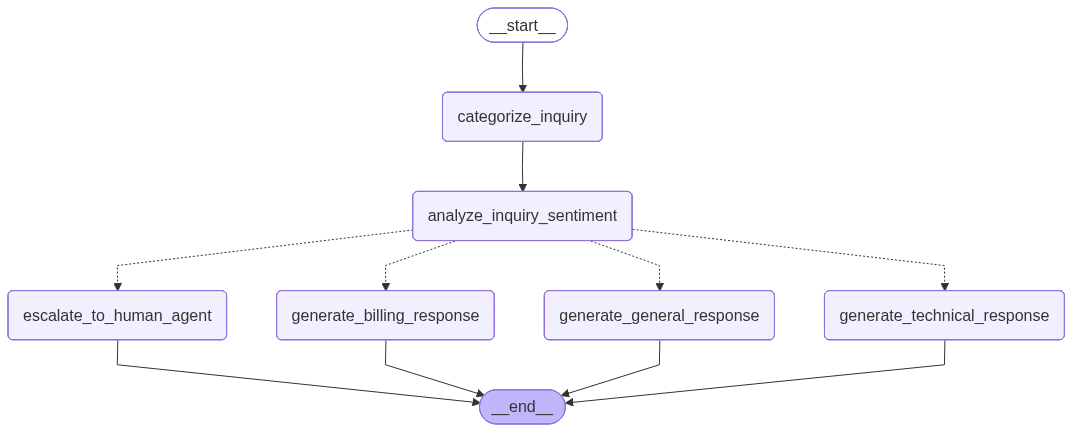

In [74]:
from IPython.display import display, Image, Markdown

display(Image(compiled_support_agent.get_graph().draw_mermaid_png()))

## Helper Function to Run the Workflow

This function takes a customer query and runs it through our compiled workflow, returning the final results (category, sentiment, and generated response).

In [75]:
def call_support_agent(agent, prompt, user_session_id, verbose=False):
    events = agent.stream(
        {"customer_query": prompt}, # initial state of the agent
        {"configurable": {"thread_id": user_session_id}},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
                print(event)

    display(Markdown(event['final_response']))

## Testing the Customer Support Workflow

Let's test the workflow with some sample queries to verify categorization, sentiment analysis, and response generation.

In [77]:
uid = 'jim001'
query = "do you support pre-trained models?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': 'do you support pre-trained models?'}
{'customer_query': 'do you support pre-trained models?', 'query_category': 'Technical'}
{'customer_query': 'do you support pre-trained models?', 'query_category': 'Technical', 'query_sentiment': 'Neutral'}
{'customer_query': 'do you support pre-trained models?', 'query_category': 'Technical', 'query_sentiment': 'Neutral', 'final_response': "Yes, we do support pre-trained models! \n\nWe offer a comprehensive range of pre-trained models designed to help you get started quickly with your machine learning projects. Our pre-trained model library includes:\n\n**Available Categories:**\n- **Natural Language Processing (NLP)** - Models for text analysis, sentiment analysis, language translation, and more\n- **Computer Vision** - Models for image recognition, object detection, image classification, and visual analysis\n- **Recommendation Systems** - Models for personalized content and product recommendations\

Yes, we do support pre-trained models! 

We offer a comprehensive range of pre-trained models designed to help you get started quickly with your machine learning projects. Our pre-trained model library includes:

**Available Categories:**
- **Natural Language Processing (NLP)** - Models for text analysis, sentiment analysis, language translation, and more
- **Computer Vision** - Models for image recognition, object detection, image classification, and visual analysis
- **Recommendation Systems** - Models for personalized content and product recommendations

These pre-trained models are ready to use out-of-the-box and can significantly reduce your development time by providing a solid foundation for your specific use cases. You can either use them directly or fine-tune them with your own data to better suit your particular requirements.

If you need more specific information about available models for your particular use case, or if you'd like guidance on which pre-trained model would work best for your project, please let me know what type of application you're working on and I'll be happy to provide more targeted recommendations.

In [78]:
query = "how do I get my invoice?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': 'how do I get my invoice?', 'query_category': 'Technical', 'query_sentiment': 'Neutral', 'final_response': "Yes, we do support pre-trained models! \n\nWe offer a comprehensive range of pre-trained models designed to help you get started quickly with your machine learning projects. Our pre-trained model library includes:\n\n**Available Categories:**\n- **Natural Language Processing (NLP)** - Models for text analysis, sentiment analysis, language translation, and more\n- **Computer Vision** - Models for image recognition, object detection, image classification, and visual analysis\n- **Recommendation Systems** - Models for personalized content and product recommendations\n\nThese pre-trained models are ready to use out-of-the-box and can significantly reduce your development time by providing a solid foundation for your specific use cases. You can either use them directly or fine-tune them with your own data to better suit your particular 

Thank you for reaching out about accessing your invoice. I'm happy to help you with that!

To get your invoice, please follow these simple steps:

1. **Log into your account** using your credentials
2. **Navigate to your account dashboard** 
3. **Look for the 'Billing' section** in your dashboard
4. **Download your detailed invoice** from that section

Your invoice will contain all the detailed information about your purchase and can be downloaded directly from the Billing area of your account dashboard.

If you have any trouble locating the Billing section or accessing your account dashboard, please don't hesitate to reach out for further assistance.

Is there anything else I can help you with regarding your billing or invoice?

In [79]:
query = "Can you tell me about your shipping policy?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=False)

Running Agent. Please wait...


Thank you for your inquiry about our shipping policy! I'm happy to provide you with the details.

**Our Shipping Policy:**

**Shipping Costs:**
- **Free shipping** for all orders $500 and above
- **$20 flat shipping fee** for orders under $500

**Delivery Timeline:**
- Standard shipping typically takes **5-7 business days** from the time your order is processed

This policy applies to our hardware products. Once your order is shipped, you'll receive tracking information so you can monitor your package's progress.

If you have any specific questions about shipping to your location or need information about expedited shipping options, please don't hesitate to ask!

In [80]:
query = "I'm fed up with this faulty hardware, I need a refund"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': "I'm fed up with this faulty hardware, I need a refund", 'query_category': 'General', 'query_sentiment': 'Neutral', 'final_response': "Thank you for your inquiry about our shipping policy! I'm happy to provide you with the details.\n\n**Our Shipping Policy:**\n\n**Shipping Costs:**\n- **Free shipping** for all orders $500 and above\n- **$20 flat shipping fee** for orders under $500\n\n**Delivery Timeline:**\n- Standard shipping typically takes **5-7 business days** from the time your order is processed\n\nThis policy applies to our hardware products. Once your order is shipped, you'll receive tracking information so you can monitor your package's progress.\n\nIf you have any specific questions about shipping to your location or need information about expedited shipping options, please don't hesitate to ask!"}
{'customer_query': "I'm fed up with this faulty hardware, I need a refund", 'query_category': 'Billing', 'query_sentiment': 'Neutr

Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!

In [81]:
query = "What are your working hours?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': 'What are your working hours?', 'query_category': 'Billing', 'query_sentiment': 'Negative', 'final_response': 'Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!'}
{'customer_query': 'What are your working hours?', 'query_category': 'General', 'query_sentiment': 'Negative', 'final_response': 'Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!'}
{'customer_query': 'What are your working hours?', 'query_category': 'General', 'query_sentiment': 'Neutral', 'final_response': 'Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!'}
{'customer_query': 'What are your working hours?', 'query_category': 'General', 'query_sentiment': 'Neutral', 'final_response': "Thank you for your inquiry about our working hours.\n\nOur support team is available to assist you from **9:00 AM to 6:00 PM, Monday through Friday**.\n\nPlease note that

Thank you for your inquiry about our working hours.

Our support team is available to assist you from **9:00 AM to 6:00 PM, Monday through Friday**.

Please note that we are closed on weekends (Saturday and Sunday). If you need assistance outside of these hours, you're welcome to reach out to us, and we'll respond to your inquiry during our next business day.

Is there anything else I can help you with today?